### 使用UNet2DModel代替BasicUNet()

In [17]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from diffusers import UNet2DModel,DDPMScheduler
from matplotlib import pyplot as plt
import pytorch_lightning as pl

In [2]:
# 设置随机种子
pl.seed_everything(42)

Global seed set to 42


42

In [3]:
# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# 加载MNIST数据集
dataset = torchvision.datasets.MNIST(
    root='mnist/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)
# 构建数据加载器
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# 获取可迭代的数据
X, y = next(iter(data_loader))
# 将数据放到设备上
X = X.to(device)
y = y.to(device)

In [5]:
# 从Diffusers库中导入UNet2DModel
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32,64,64),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D"
    )
)

In [6]:
# 采样
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)

In [7]:
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D

In [15]:
for i in range(n_steps):
    # 创建噪声
    amount = torch.ones((x.shape[0],)).to(device) * (1 -(i / n_steps))
    with torch.no_grad():
        pred = model(x.to(device),0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

通过绘制函数曲线，展示调度器中不同的系数的曲线，例如：
- $\sqrt{\bar{\alpha}_t}$
- $\sqrt{(1 - \bar{\alpha_t})}$

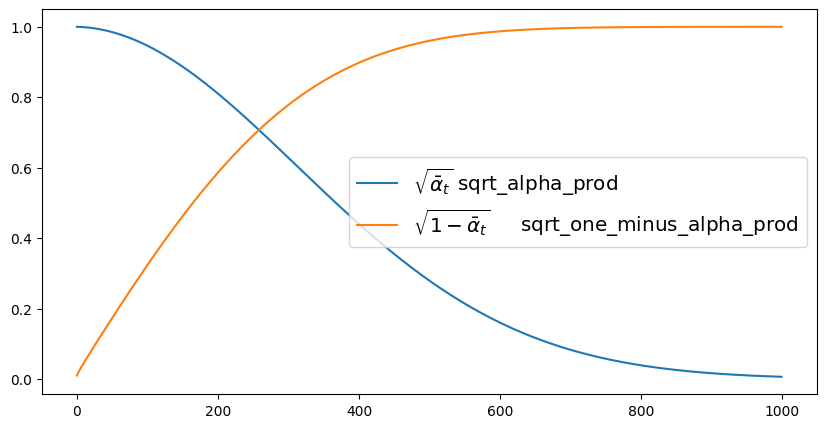

In [24]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.figure(figsize=(10, 5))
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5,
    label = r"$\sqrt{\bar{\alpha}_t}$"+"\tsqrt_alpha_prod"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label = r"$\sqrt{1 - \bar{\alpha}_t}$"+"\tsqrt_one_minus_alpha_prod"
)
plt.legend(
    fontsize = 'x-large',
)
plt.show()